In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# Building ARIMA Models
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Libraries for Evaluation
from sklearn.metrics import mean_squared_error
from math import sqrt

In [2]:
%matplotlib inline

In [3]:
# load dataset
df_AAL = pd.read_csv('../../datasets/AAL.csv', header=0, index_col=0)
df_AAL.head()

,Open,High,Low,Close,Volume
Date,,,,,
6/11/2018,43.25,44.93,43.25,44.16,"6,440,746"
6/12/2018,44.23,44.30,43.09,43.41,"5,204,620"
6/13/2018,43.39,43.69,42.83,42.92,"5,988,999"
6/14/2018,43.06,43.49,42.80,43.08,"4,019,334"
6/15/2018,43.06,43.11,42.32,42.77,"7,031,967"


<class 'pandas.core.frame.DataFrame'>
Index: 1258 entries, 6/11/2018 to 6/8/2023
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1258 non-null   float64
 1   High    1258 non-null   float64
 2   Low     1258 non-null   float64
 3   Close   1258 non-null   float64
 4   Volume  1258 non-null   object 
dtypes: float64(4), object(1)
memory usage: 59.0+ KB


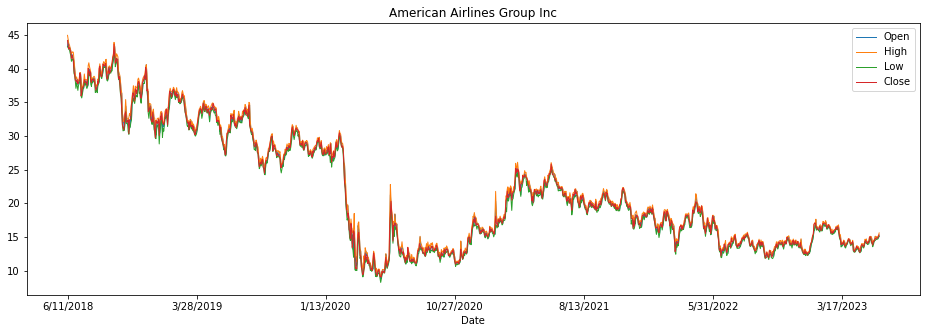

In [4]:
df_AAL.info()
df_AAL.plot(figsize=(16,5),lw=1, title="American Airlines Group Inc")
plt.show()

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

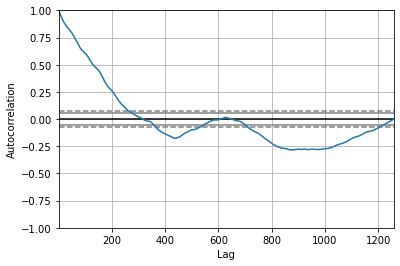

In [5]:
autocorrelation_plot(df_AAL[["Open","High","Low","Close"]])

### Choosing Close Columns for model predictions

<class 'pandas.core.series.Series'>
Index: 1258 entries, 6/11/2018 to 6/8/2023
Series name: Close
Non-Null Count  Dtype  
--------------  -----  
1258 non-null   float64
dtypes: float64(1)
memory usage: 19.7+ KB


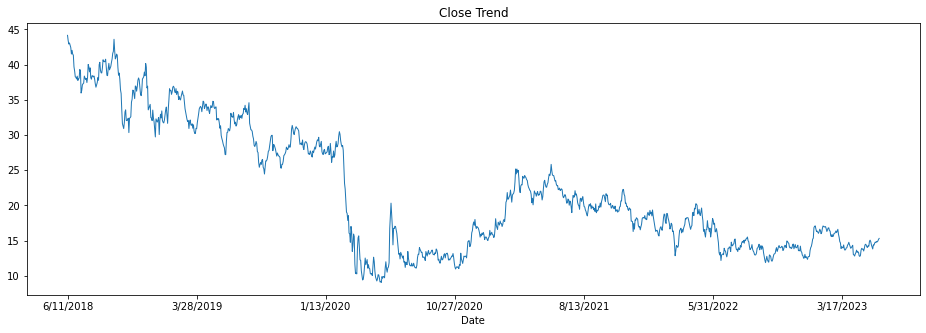

In [6]:
df_close = df_AAL["Close"]
df_close.info()
df_close.plot(figsize=(16,5),lw=1, title="Close Trend")
plt.show()

In [7]:
df_close

Date
6/11/2018    44.16
6/12/2018    43.41
6/13/2018    42.92
6/14/2018    43.08
6/15/2018    42.77
             ...  
6/2/2023     14.87
6/5/2023     14.81
6/6/2023     14.93
6/7/2023     15.16
6/8/2023     15.30
Name: Close, Length: 1258, dtype: float64

<AxesSubplot:>

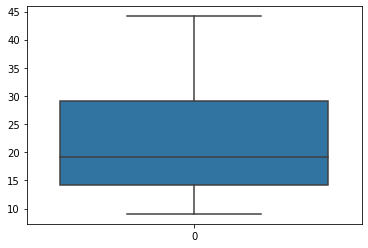

In [11]:
sns.boxplot(data=df_close)

### Split data for train and test

In [12]:
# Split the data for train and test
df_train = df_close[:1228].copy()
df_test = df_close[1228:].copy()

In [13]:
# Creating function to display ACF anf PACF plot
def plot_correlation(df):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5), dpi=80)
    # ACF
    plot_acf(df, ax=ax1, lags=30)
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    
    # PACF
    plot_pacf(df, ax=ax2, lags=20)
    plt.xlabel('Lag')
    plt.ylabel('Partial Autocorrelation')

    # Lighten the borders
    ax1.spines['top'].set_alpha(.3); ax2.spines['top'].set_alpha(.3)
    ax1.spines['bottom'].set_alpha(.3); ax2.spines['bottom'].set_alpha(.3)
    ax1.spines['right'].set_alpha(.3); ax2.spines['right'].set_alpha(.3)
    ax1.spines['left'].set_alpha(.3); ax2.spines['left'].set_alpha(.3)

    ax1.tick_params(axis='both', labelsize=10)
    ax2.tick_params(axis='both', labelsize=10)
    plt.show()

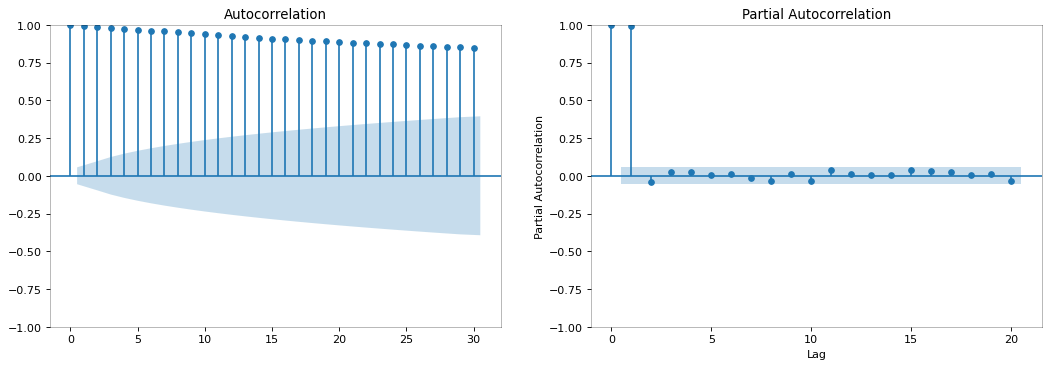

In [14]:
plot_correlation(df_train)

### Get p-value with ADF and KPSS test

In [15]:
#perform augmented Dickey-Fuller test to check if stationary
def ADF(df):
    result = adfuller(df)

    # Extract ADF Values
    print('Column Name: %s' % "Close Variable")
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

In [16]:
ADF(df_train)

Column Name: Close Variable
ADF Statistic: -2.335095
p-value: 0.160899
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


In [17]:
# KPSS Test 
def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c")
    kpss_output = pd.Series(kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"])
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

In [18]:
kpss_test(df_train.values)

Results of KPSS Test:
Test Statistic            3.910548
p-value                   0.010000
Lags Used                20.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


## Transform to stationary

p.value: -0.4899999999999949


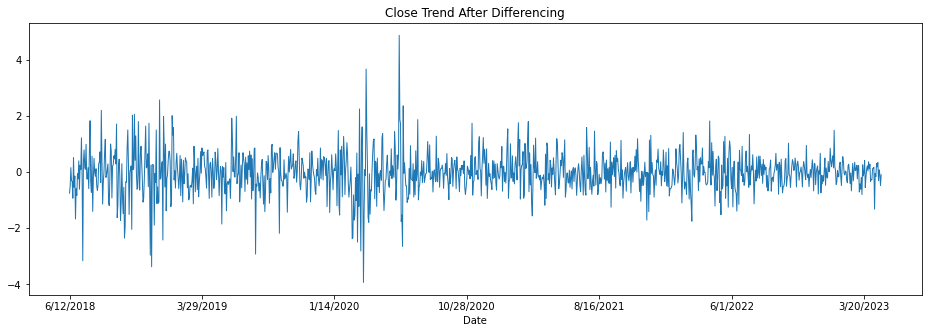

In [19]:
# Perform differencing
diff = 0
def to_stationary(df):
    df_diff = df.diff().dropna()
    if df_diff[1] <= 0.05:
        diff +=1
        return df_diff
    else:
        return to_stationary(df_diff)

df_train_diff = to_stationary(df_train)
df_train_diff.plot(figsize=(16,5), lw=1, title="Close Trend After Differencing")
print(f"p.value: {df_diff[1]}")
plt.show()

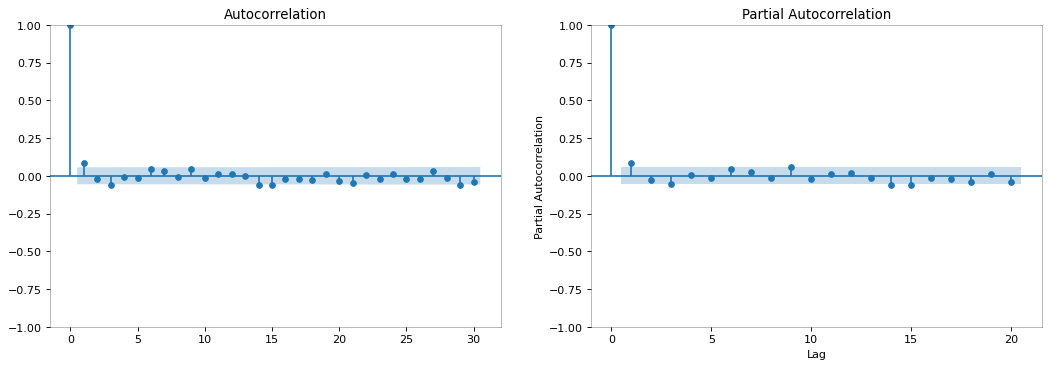

In [20]:
plot_correlation(df_train_diff)

## Determine model parameters p, q

In [61]:
# library that determine best parameters for ARIMA model
import pmdarima as pm
from pmdarima import auto_arima

In [62]:
best_model = auto_arima(df_train, start_p=0, start_q=0,
                          max_p=3, max_q=3,m=12,start_P=0,start_Q=0, 
                          max_P = 3, max_Q = 3,
                          seasonal=True,
                          d=diff,D=diff,trace=True,
                          error_action='ignore',   
                          suppress_warnings=True,  
                          stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=3503.821, Time=0.35 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=3150.797, Time=0.73 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=5.55 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=3497.791, Time=0.37 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=3015.130, Time=1.60 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=11.07 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=4.51 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=3026.243, Time=1.00 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=3016.839, Time=1.61 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=3016.992, Time=1.97 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=3015.025, Time=2.00 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=3150.805, Time=0.77 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=inf, Time=12.59 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=6.46 sec
 ARIMA(0,1,2)(2,1,0)[12]             : AIC

In [66]:
# Get best SARIMA model
order = best_model.order
seasonal_order = best_model.seasonal_order

(2, 1, 0, 12)

## Fit the ARIMA Model

In [21]:
model = ARIMA(df_train, order=order)
model_fit = model.fit()
print(model_fit.summary())

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1228
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -1345.821
Date:                Sun, 09 Jul 2023   AIC                           2695.643
Time:                        11:50:47   BIC                           2705.868
Sample:                             0   HQIC                          2699.490
                               - 1228                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0861      0.022      3.870      0.000       0.042       0.130
sigma2         0.5251      0.012     44.079      0.000       0.502       0.548
Ljung-Box (L1) (Q):                   0.00   Jarque-

## Make time series prediction

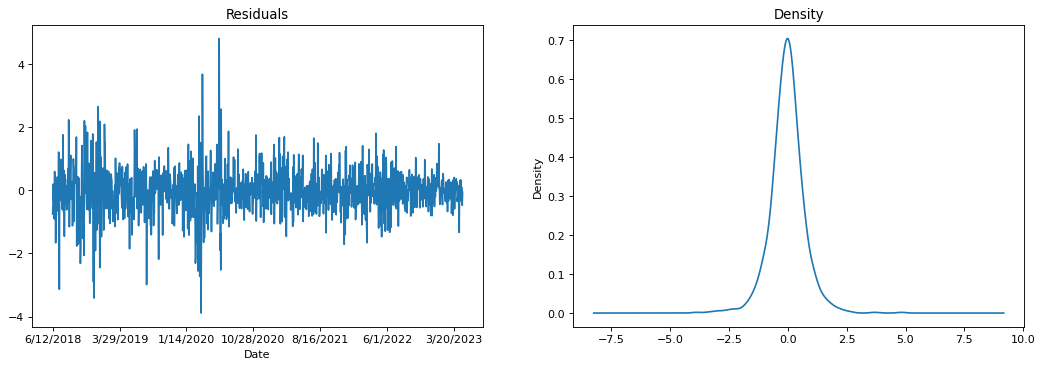

In [22]:
# Getting residuals pattern
# To make sure model capture adequate information from the data
residuals = model_fit.resid[1:]
fig,ax=plt.subplots(1,2, figsize=(16,5), dpi=80)
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1])
plt.show()

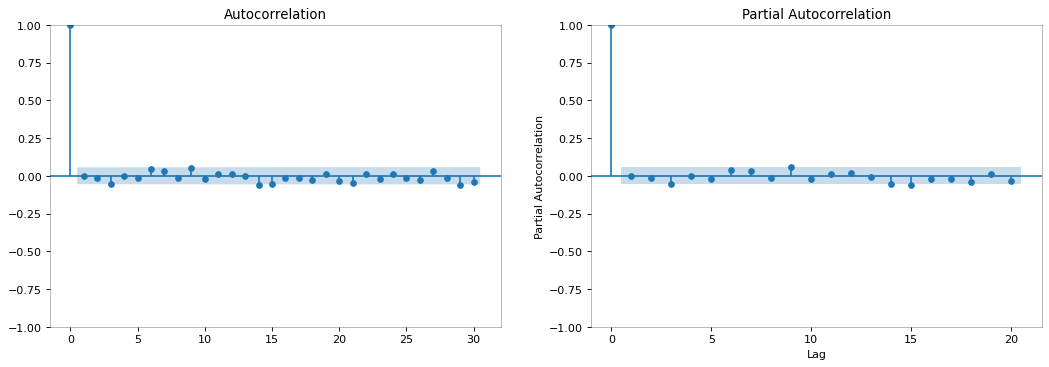

In [23]:
plot_correlation(residuals)

In [24]:
residuals

Date
6/12/2018   -0.750002
6/13/2018   -0.425902
6/14/2018    0.196667
6/15/2018   -0.326932
6/18/2018   -0.301852
               ...   
4/20/2023   -0.338071
4/21/2023    0.109107
4/24/2023   -0.089394
4/25/2023   -0.472303
4/26/2023   -0.059336
Length: 1227, dtype: float64

In [30]:
forecast = model_fit.forecast(len(df_test))

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [31]:
forecast.index = df_test.index
new_df = pd.concat([forecast, df_test], axis=1)
new_df

,predicted_mean,Close
Date,,
4/27/2023,12.734891,12.88
4/28/2023,12.734891,13.64
5/1/2023,12.734891,13.89
5/2/2023,12.734891,13.77
5/3/2023,12.734891,13.79
5/4/2023,12.734891,13.51
5/5/2023,12.734891,13.87
5/8/2023,12.734891,14.36
5/9/2023,12.734891,14.47


<AxesSubplot:xlabel='Date'>

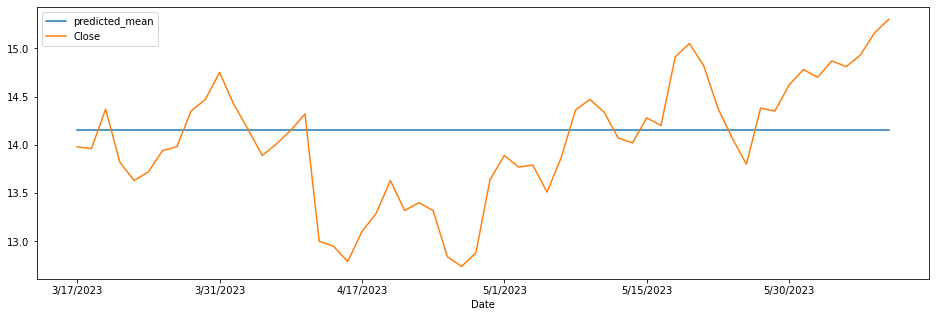

In [37]:
new_df.plot(figsize=(16,5))

## Fit the SARIMAX Model

In [34]:
# Splitting data into training and testing
training = pd.DataFrame(df.Close[0:int(len(df.Close)*0.70)])
testing = pd.DataFrame(df.Close[int(len(df.Close)*0.70):int(len(df.Close))])

In [35]:
final_model = SARIMAX(train,order=(0,1,1),seasonal_order=(2,1,0,12)) # Best model:  ARIMA(0,1,1)(2,1,0)[12] 
result = final_model.fit()
print(result.summary())

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.26898D+00    |proj g|=  3.22200D-01

At iterate    5    f=  1.23245D+00    |proj g|=  1.32549D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      8     12      1     0     0   2.797D-06   1.232D+00
  F =   1.2324517505139645     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                                      SARIMAX Results                                      
Dep. Variable:                          

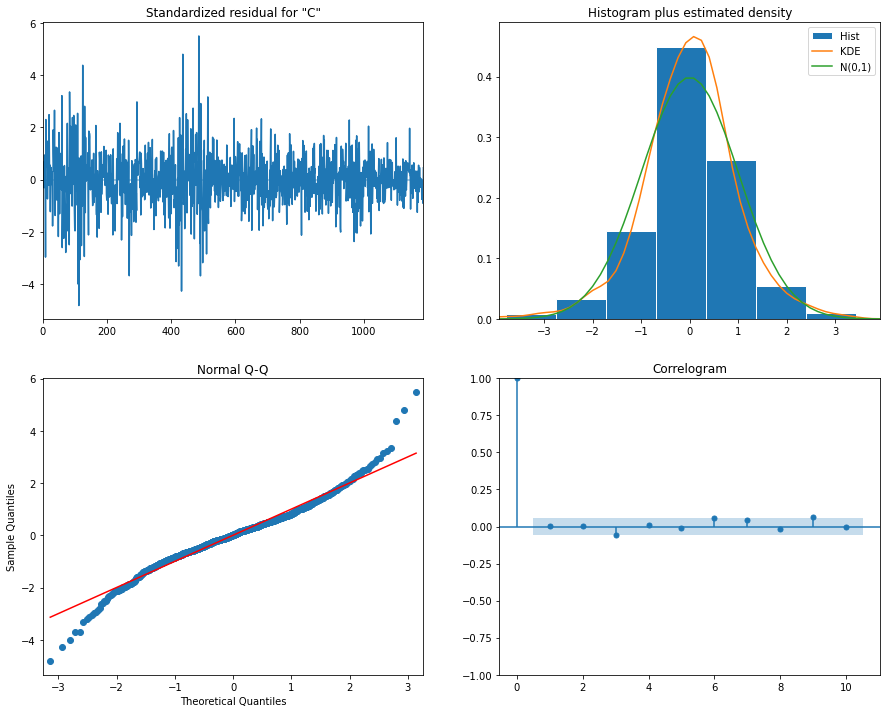

In [36]:
result.plot_diagnostics(figsize=(15, 12));

In [50]:
result.resid.min()

-22.90999989704258

In [37]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
# Best model:  ARIMA(2,2,0)(2,2,0)[12]
predictions = result.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(2,2,0)(2,2,0,12) Predictions')# Plot predictions against known values

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [43]:
len(predictions)

58

In [44]:
len(test)

58

In [38]:
predictions.index = test.index
joined_df = pd.concat([predictions, test], axis=1)
joined_df

,"SARIMA(2,2,0)(2,2,0,12) Predictions",Close
Date,,
3/17/2023,14.126541,13.98
3/20/2023,14.349367,13.96
3/21/2023,14.464984,14.37
3/22/2023,14.234157,13.82
3/23/2023,14.234207,13.63
3/24/2023,14.481203,13.72
3/27/2023,14.139450,13.94
3/28/2023,13.942513,13.98
3/29/2023,13.811739,14.35


[Text(0.5, 0, 'Date'), Text(0, 0.5, 'Production')]

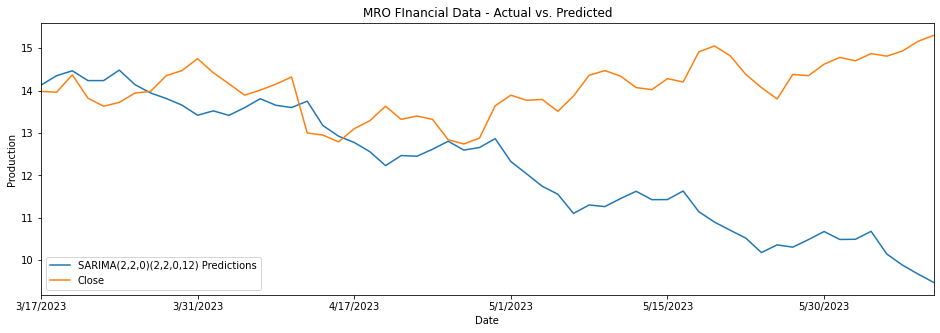

In [39]:
title = 'MRO FInancial Data - Actual vs. Predicted'
ylabel='Production'
xlabel='Date'
ax = joined_df.plot(legend=True, figsize=(16,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)

In [ ]:
# Residual 1
residuals = abs(predictions - test)
residuals

In [53]:
# Residual 2
residuals2 = abs(predictions - test)
residuals2

Date
3/17/2023    0.146541
3/20/2023    0.389367
3/21/2023    0.094984
3/22/2023    0.414157
3/23/2023    0.604207
3/24/2023    0.761203
3/27/2023    0.199450
3/28/2023    0.037487
3/29/2023    0.538261
3/30/2023    0.813386
3/31/2023    1.332576
4/3/2023     0.899280
4/4/2023     0.744961
4/5/2023     0.294785
4/6/2023     0.203036
4/10/2023    0.497878
4/11/2023    0.721193
4/12/2023    0.749073
4/13/2023    0.224741
4/14/2023    0.134205
4/17/2023    0.324190
4/18/2023    0.731996
4/19/2023    1.399666
4/20/2023    0.852250
4/21/2023    0.948778
4/24/2023    0.703766
4/25/2023    0.035312
4/26/2023    0.143868
4/27/2023    0.222770
4/28/2023    0.773542
5/1/2023     1.563623
5/2/2023     1.731653
5/3/2023     2.045678
5/4/2023     1.953113
5/5/2023     2.765925
5/8/2023     3.056537
5/9/2023     3.205697
5/10/2023    2.886560
5/11/2023    2.444133
5/12/2023    2.591804
5/15/2023    2.849523
5/16/2023    2.567869
5/17/2023    3.764421
5/18/2023    4.149830
5/19/2023    4.110895
5/22/

In [48]:
len(residuals)

58

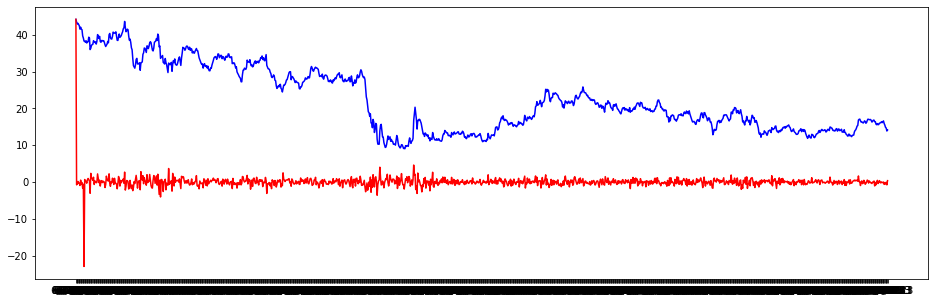

In [51]:
# SARIMA model residuals plot
plt.figure(figsize=(16,5))
plt.plot(train, 'b')
plt.plot(result.resid, 'r')
plt.show()

In [56]:
resid2 = abs(result.resid)

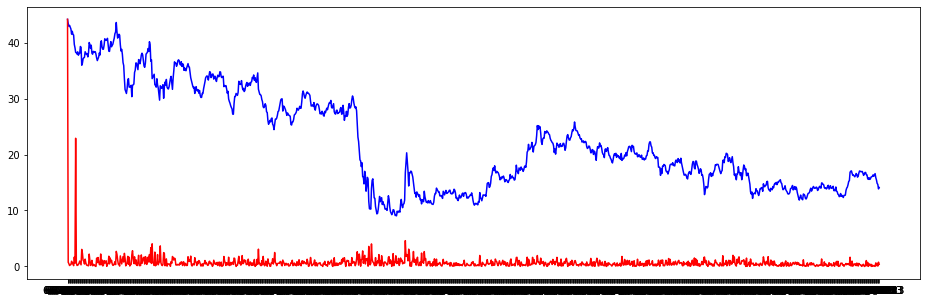

In [57]:
# SARIMA model residuals plot
plt.figure(figsize=(16,5))
plt.plot(train, 'b')
plt.plot(resid2, 'r')
plt.show()

In [69]:
resid2.to_csv('AAL_residual.csv', sep=',', index=False, encoding='utf-8')

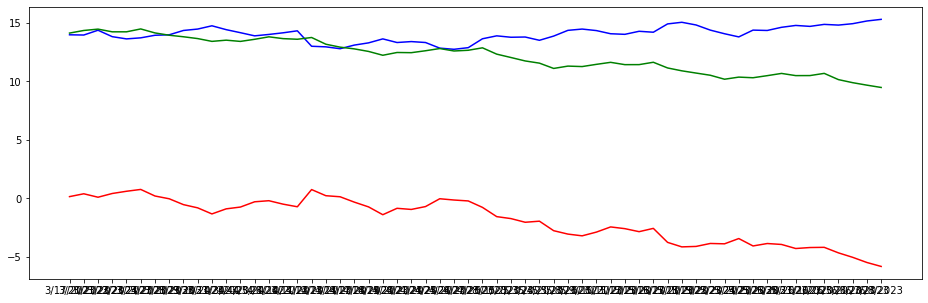

In [55]:
# SARIMA predictions residual plot
plt.figure(figsize=(16,5))
plt.plot(test, 'b')
plt.plot(residuals, 'r')
plt.plot(predictions, 'g')
plt.show()

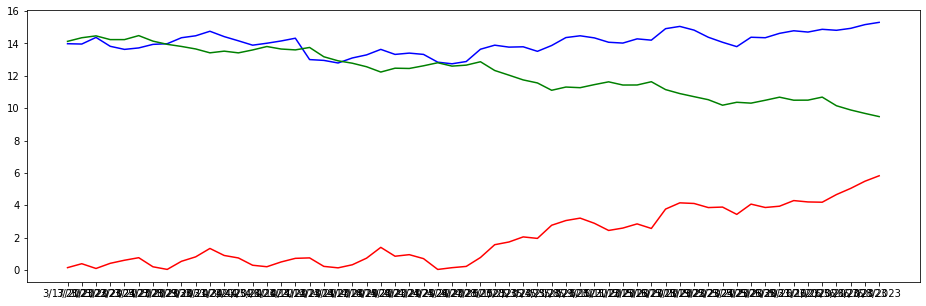

In [54]:
# SARIMA predictions residual plot with absolute function
plt.figure(figsize=(16,5))
plt.plot(test, 'b')
plt.plot(residuals2, 'r')
plt.plot(predictions, 'g')
plt.show()